# Load Datasets from S3 🕸️🕸️

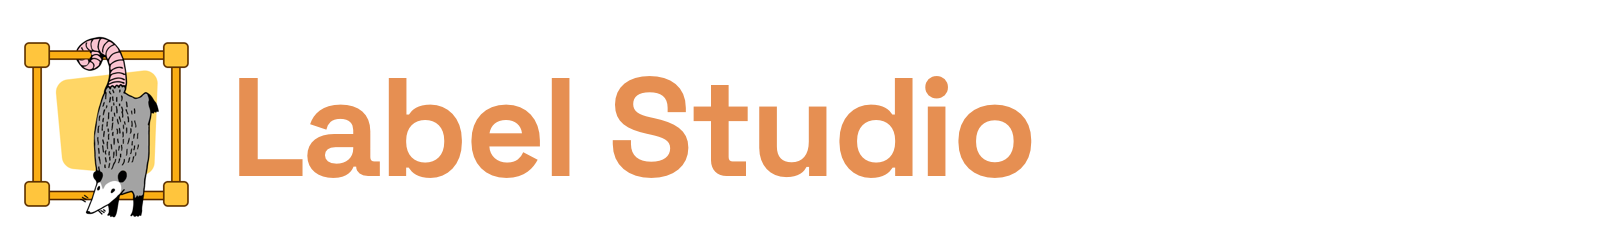

In [ ]:
## Imports to load from S3 bucket
import os
import boto3
import ipywidgets as widgets

In [ ]:
## S3_ACCESS_KEY_ID & S3_SECRET_ACCESS_KEY should be set as Env variables
key_id = os.environ.get('S3_ACCESS_KEY_ID')
secret_key = os.environ.get('S3_SECRET_ACCESS_KEY')
## Load the bucket and file path 
bucket_name = os.environ['bucket']

if(key_id is None or secret_key is None or bucket_name is None):
    raise TypeError("An env variables is not set")

In [ ]:
import ipywidgets as widgets
from IPython.display import display

# Creating a box layout for better widget organization
box_layout = widgets.Layout(display='flex',
                            flex_flow='row',
                            justify_content='space-between',
                            width='50%')

# Text input widget
text = widgets.Text(
    description='Model Name:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(flex='2 1 auto', width='auto')
)

# Button widget
button = widgets.Button(description="Save",
                        button_style='primary',  # Apply a Bootstrap theme
                        layout=widgets.Layout(flex='1 1 auto', width='auto'))

# Function to handle button click
def on_button_clicked(b):
    print("Saved text: ", text.value)

# Linking the button click event to the function
button.on_click(on_button_clicked)

# Using a VBox for vertical stacking of widgets
widget_box = widgets.VBox([text, button], layout=box_layout)

# Displaying the widgets
display(widget_box)

In [ ]:
## Get path and data from desired labeled model datasets
model_name= text.value
full_path= f"{bucket_name}/datasets/labeled/token-classification/{model_name}"
print(f"\n Getting from S3 bucket: {bucket_name}")
print(f"\nIn path: {full_path}")
session = boto3.session.Session()
s3_client = session.client('s3',
                        region_name='nyc3',
                        endpoint_url='https://nyc3.digitaloceanspaces.com',
                        aws_access_key_id=key_id,
                        aws_secret_access_key=secret_key)

In [ ]:
import pandas as pd
def assignSeq2Df(seq):
    task=seq.get("task")
    key=list(task.get("data").keys())[0]
    input_sentence=task.get("data")[key]
    sentenceByToken=input_sentence.split(" ")
    idFromToken=[]
    for token in sentenceByToken:
        idFromToken.append(0)
    labels=seq.get("result")
    if(len(results) > 0):
        for label in labels:
            i=0
            for token in sentenceByToken:
                if(label.get("value").get("text") == token):
                    idFromToken[i]=(label.get("value").get("labels")[0])
                i+=1
    return {
    "sentenceByToken":sentenceByToken,
    "idFromToken":idFromToken
    }

In [ ]:
import json
import pandas as pd
from tqdm.notebook import tqdm
paginator=s3_client.get_paginator('list_objects_v2')
pages=paginator.paginate(Bucket=bucket_name,Prefix=f"datasets/labeled/token-classification/{model_name}")

tags=[
 "O"
]

tags2id = {
"0":0}
df=[]
for page in tqdm(pages, desc='Initializing...'):
    page_objects = page.get('Contents', [])
    i=0
    j=1
    for obj in tqdm(page_objects, desc='Loading annotations ...', leave=False):
        data = s3_client.get_object(Bucket=bucket_name, Key=obj.get('Key'))
        content =(data['Body'].read()).decode("utf-8")
        if(i>0 and type(content) is str):
            annotation=json.loads(content)
            results=annotation.get("result")
            if(len(results) <= 0):
                continue
            for result in results:
                label=(result.get("value")).get("labels")[0]
                if(label not in tags2id and label not  in tags):
                    tags2id={**tags2id,label:j}
                    tags.append(label)
                    j+=1
            seq = assignSeq2Df(annotation)
            df.append(
                {
                    "_id" : i,
                "tokens":seq.get("sentenceByToken"),
                "ner_tags":seq.get("idFromToken")
                }
            )
        i+=1
df=pd.DataFrame(df)
print(f"Finished processing a total amount of {len(df.index)} annotations")

In [ ]:
## Get the first three to see the structure
df.head(3)

In [ ]:
### Save tags & tags2id for training metadata
with open('tags2id.json', 'w') as fp:
    json.dump(tags2id, fp)
    print("Saved tags2id.json")
    


with open('tags.json', 'w') as fp:
    json.dump({
    "tags":tags}, fp)
    print("Saved tags.json")

In [ ]:
### Save the dataframe to be loaded inside tran notebook

df.to_csv(path_or_buf='./dataset.csv',index=False)
print(f"\nDataframe creation completed")